In [53]:
import json
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [27]:
with open('solution_TPS_Mi_500_Mb_52_nu_0.02_Hermite.json', 'r') as f:
    dataTPS500 = json.load(f)

In [28]:
nu = dataTPS500['nu']
rbf = dataTPS500['RBF']
Mi = np.array(dataTPS500['points']['Interior'])
Mb = np.array(dataTPS500['points']['boundary'])
uh_t = dataTPS500['solution']

In [68]:
def sol_uh(Mi, uh_t, t, j=0):
    X = Mi.copy()
    # data coordinates and values
    x = X[:,0]
    y = X[:,1]
    z = np.array(uh_t[t])[:, j]

    # target grid to interpolate to
    xi = yi = np.arange(0, 1, 1/(X.shape[0]))
    xi,yi = np.meshgrid(xi,yi)

    # set mask
    #mask = np.sqrt((xi - domain.c_x)**2 + (yi - domain.c_y)**2) < domain.radius

    # interpolate
    zi = griddata((x,y),z,(xi,yi), method='cubic')

    # mask out the field
    #zi[mask] = np.nan

    # plot
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    im = plt.contourf(xi,yi,zi)
    plt.plot(x,y,'k.')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(im, cax=cax)
    plt.clim(0.72, 1.0)
    #plt.savefig('interpolated.png',dpi=100)
    plt.show()

In [69]:
@interact
def show_solution(t=(0, 10, 1)):
    return sol_uh(Mi, uh_t, str(t/10), j=1)

interactive(children=(IntSlider(value=5, description='t', max=10), Output()), _dom_classes=('widget-interact',…

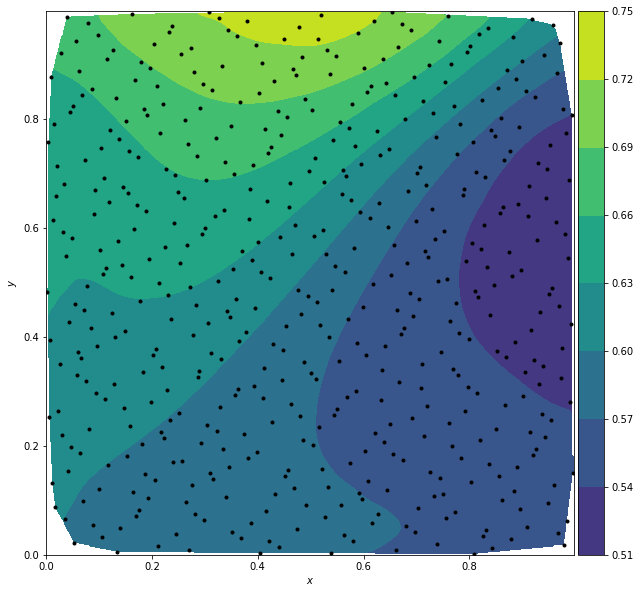

In [52]:
X = Mi.copy()
# data coordinates and values
x = X[:,0]
y = X[:,1]
z = np.array(uh_t['0.5'])[:, 0]

# target grid to interpolate to
xi = yi = np.arange(0, 1, 1/(X.shape[0]))
xi,yi = np.meshgrid(xi,yi)

# set mask
#mask = np.sqrt((xi - domain.c_x)**2 + (yi - domain.c_y)**2) < domain.radius

# interpolate
zi = griddata((x,y),z,(xi,yi), method='cubic')

# mask out the field
#zi[mask] = np.nan

# plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
im = plt.contourf(xi,yi,zi)
plt.plot(x,y,'k.')
plt.xlabel('$x$')
plt.ylabel('$y$')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)
plt.clim(0.48, 0.76)
#plt.savefig('interpolated.png',dpi=100)
plt.show()